<a href="https://colab.research.google.com/github/ORAzzQWQ/NLP_2024/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part I: Data Pre-processing

In [ ]:
import pandas as pd

In [ ]:
# Download the Google Analogy dataset
!wget http://download.tensorflow.org/data/questions-words.txt

--2024-09-19 14:17:13--  http://download.tensorflow.org/data/questions-words.txt
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.202.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 603955 (590K) [text/plain]
Saving to: ‘questions-words.txt’

questions-words.txt 100%[===================>] 589.80K  --.-KB/s    in 0.003s  

2024-09-19 14:17:14 (201 MB/s) - ‘questions-words.txt’ saved [603955/603955]



In [ ]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [ ]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [23]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.

questions = []
categories = []
sub_categories = []
colon_count = 0

for line in data:
    line = line.strip()

    if line.startswith(":"):
        colon_count += 1
        section_name = line
        continue

    if colon_count <= 5:
        categories.append("semantic")
    else:
        categories.append("syntatic")

    sub_categories.append(section_name)
    questions.append(line)

In [24]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)
print(df)

                             Question  Category                 SubCategory
0          Athens Greece Baghdad Iraq  semantic  : capital-common-countries
1      Athens Greece Bangkok Thailand  semantic  : capital-common-countries
2         Athens Greece Beijing China  semantic  : capital-common-countries
3        Athens Greece Berlin Germany  semantic  : capital-common-countries
4      Athens Greece Bern Switzerland  semantic  : capital-common-countries
...                               ...       ...                         ...
19539         write writes talk talks  syntatic        : gram9-plural-verbs
19540       write writes think thinks  syntatic        : gram9-plural-verbs
19541    write writes vanish vanishes  syntatic        : gram9-plural-verbs
19542         write writes walk walks  syntatic        : gram9-plural-verbs
19543         write writes work works  syntatic        : gram9-plural-verbs

[19544 rows x 3 columns]


In [25]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,semantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,semantic,: capital-common-countries
2,Athens Greece Beijing China,semantic,: capital-common-countries
3,Athens Greece Berlin Germany,semantic,: capital-common-countries
4,Athens Greece Bern Switzerland,semantic,: capital-common-countries


In [26]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [22]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [27]:
data = pd.read_csv("questions-words.csv")

In [28]:
MODEL_NAME = "glove-wiki-gigaword-100"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

[==================================================] 100.0% 128.1/128.1MB downloaded
The Gensim model loaded successfully!


In [31]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      # tqdm(): show the processing line
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      # ask ChatGPT how to use
      word_a, word_b, word_c, gold_answer = analogy.split()

      try:
        result_vector = model[word_b] + model[word_c] - model[word_a]

        predicted_word = model.most_similar(positive=[result_vector], topn=1)[0][0]

        preds.append(predicted_word)
        golds.append(gold_answer)

      except KeyError as e:
        # print(f"Word not in vocabulary: {e}")
        preds.append(None)
        golds.append(gold_answer)


100%|██████████| 19544/19544 [02:55<00:00, 111.17it/s]


In [32]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: semantic, Accuracy: 2.2663208929980834%
Category: syntatic, Accuracy: 14.341920374707259%
Sub-Category: capital-common-countries, Accuracy: 0.0%
Sub-Category: capital-world, Accuracy: 0.0%
Sub-Category: currency, Accuracy: 0.0%
Sub-Category: city-in-state, Accuracy: 0.0%
Sub-Category: family, Accuracy: 39.723320158102766%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 6.048387096774194%
Sub-Category: gram2-opposite, Accuracy: 6.280788177339902%
Sub-Category: gram3-comparative, Accuracy: 30.705705705705704%
Sub-Category: gram4-superlative, Accuracy: 25.49019607843137%
Sub-Category: gram5-present-participle, Accuracy: 13.446969696969695%
Sub-Category: gram6-nationality-adjective, Accuracy: 0.0%
Sub-Category: gram7-past-tense, Accuracy: 11.346153846153847%
Sub-Category: gram8-plural, Accuracy: 15.54054054054054%
Sub-Category: gram9-plural-verbs, Accuracy: 22.873563218390807%


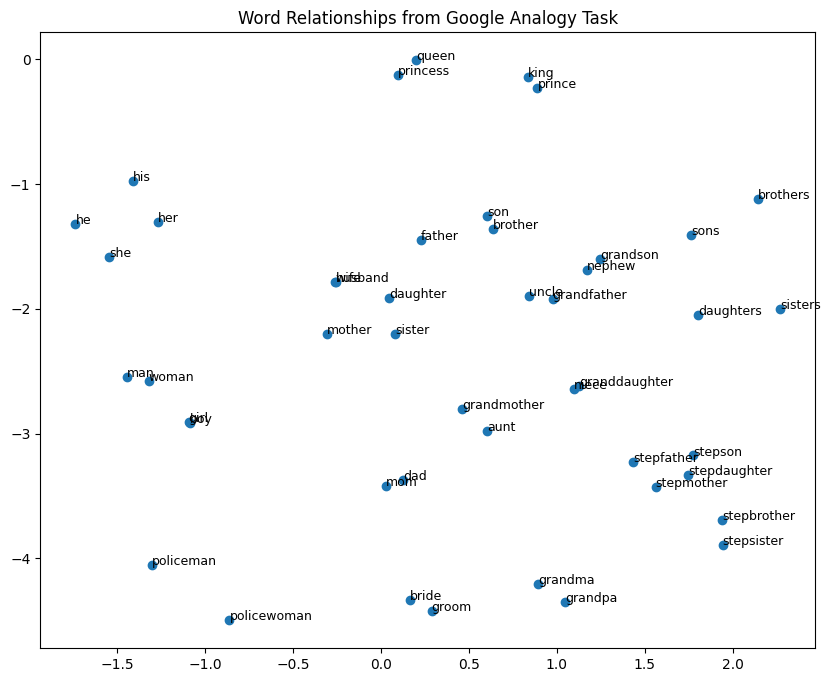

<Figure size 640x480 with 0 Axes>

In [38]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`
# ask ChatGPT how to use
family_words = data[data["SubCategory"] == ": family"]["Question"].str.split().tolist()
family_words = [word for sublist in family_words for word in sublist]
family_words = list(set(family_words))

words_vectors = []
words = []
for word in family_words:
    if word in model:
        words_vectors.append(model[word])
        words.append(word)

words_vectors = np.array(words_vectors)
tsne = TSNE(n_components=2, random_state=0)
reduced_vectors = tsne.fit_transform(words_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])

# add tag
for i, word in enumerate(words):
    plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], word, fontsize=9)

plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")

### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
!gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
!gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
!gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
!gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
!gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles), except the last file.
!gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
!gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
!gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
!gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
!gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
!gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

In [ ]:
# Extract the downloaded wiki_texts_parts files.
!gunzip -k wiki_texts_part_*.gz

In [ ]:
# Combine the extracted wiki_texts_parts files.
!cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [ ]:
# Check the first ten lines of the combined file
!head -n 10 wiki_texts_combined.txt

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [ ]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random

wiki_txt_path = "wiki_texts_combined.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.

with open(wiki_txt_path, "r", encoding="utf-8") as f:
    with open(output_path, "w", encoding="utf-8") as output_file:
    # TODO4: Sample `20%` Wikipedia articles
    # Write your code here

In [ ]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.

In [ ]:
data = pd.read_csv("questions-words.csv")

In [ ]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """

In [ ]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`


plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")